<a href="https://colab.research.google.com/github/Latamila/ConsumoEnergiaSerieTemporal/blob/main/ConsumoDeEnergia1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from platform import python_version
print('versão: ', python_version())

versão:  3.10.12


In [ ]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.5 MB/s eta 0:00:00


In [ ]:
!pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
#formatando as saídas dos gráficos
plt.style.use('fivethirtyeight')#estilo
pd.set_option('display.expand_frame_repr', False)#formatação
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
m.rcParams['axes.labelsize'] = 14  #tamanho dos labels do eixo x, y e textoCor
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'


In [ ]:
#versões dos pacotes usados neste notebook
%reload_ext watermark
%watermark -a 'Camila' --iversions

Author: Camila

matplotlib : 3.7.1
numpy      : 1.23.5
pandas     : 1.5.3
statsmodels: 0.14.0
seaborn    : 0.12.2



In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [ ]:
df = pd.read_csv('dataset.csv', header= None)
#header serve para qualquer seus dados não vem com cabeçalho
#ou seja, nome das colunas

In [ ]:
df_semcabecalho = pd.read_csv('dataset.csv')

In [ ]:
df_semcabecalho.head() #uma linha de fatos veio pro cabeçalho
#e isso não é esperado.

,2004-01,112
0,2004-02,118
1,2004-03,132
2,2004-04,129
3,2004-05,121
4,2004-06,135


In [ ]:
df.head()#assim não perdemos nenhum evento.

,0,1
0,2004-01,112
1,2004-02,118
2,2004-03,132
3,2004-04,129
4,2004-05,121


Perceba que são duas colunas. Esses dados representam uma serie univariada, pois temos uma variavel aleatoria (valor do consumo de energia) e a data, que representa o indice da serie. Veja que a serie é mensal.

In [ ]:
df.columns = ['mes','consumo_energia']

In [ ]:
df.head()

,mes,consumo_energia
0,2004-01,112
1,2004-02,118
2,2004-03,132
3,2004-04,129
4,2004-05,121


In [ ]:
df.describe()

,consumo_energia
count,144.00000
mean,280.31250
std,119.95369
min,104.00000
25%,180.00000
50%,265.50000
75%,360.50000
max,622.00000


In [ ]:
dados = df

In [ ]:
dados.max()

mes                2015-12
consumo_energia        622
dtype: object

In [ ]:
#vamos coletar o periodo completo da serie temporal
print('Início do Periodo de tempo: {}\nFinal do Periodo de tempo: {}'.format(dados.mes.min(),dados.mes.max()))

Início do Periodo de tempo: 2004-01
Final do Periodo de tempo: 2015-12


In [ ]:
dados.shape

(144, 2)

In [ ]:
dados.dtypes

mes                object
consumo_energia     int64
dtype: object

In [ ]:
type(dados) #tipo dataframe nao é o ideal para series temporais

pandas.core.frame.DataFrame

In [ ]:
dados['mes'] = pd.to_datetime(dados['mes'], format = '%Y-%m')

In [ ]:
dados.head()

,mes,consumo_energia
0,2004-01-01,112
1,2004-02-01,118
2,2004-03-01,132
3,2004-04-01,129
4,2004-05-01,121


In [ ]:
#trocar coluna data para indice
dados_serie = dados.set_index('mes')

In [ ]:
dados_serie.head()

,consumo_energia
mes,
2004-01-01,112
2004-02-01,118
2004-03-01,132
2004-04-01,129
2004-05-01,121


Isso ajudara muito.

In [ ]:
#visualizando o indice
dados_serie.index

DatetimeIndex(['2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01', '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01', '2004-09-01', '2004-10-01',
               ...
               '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01'], dtype='datetime64[ns]', name='mes', length=144, freq=None)

In [ ]:
#valores nulos
dados_serie.isnull().sum()

consumo_energia    0
dtype: int64

#MODELAGEM ESTATISTICA

<Axes: xlabel='mes'>

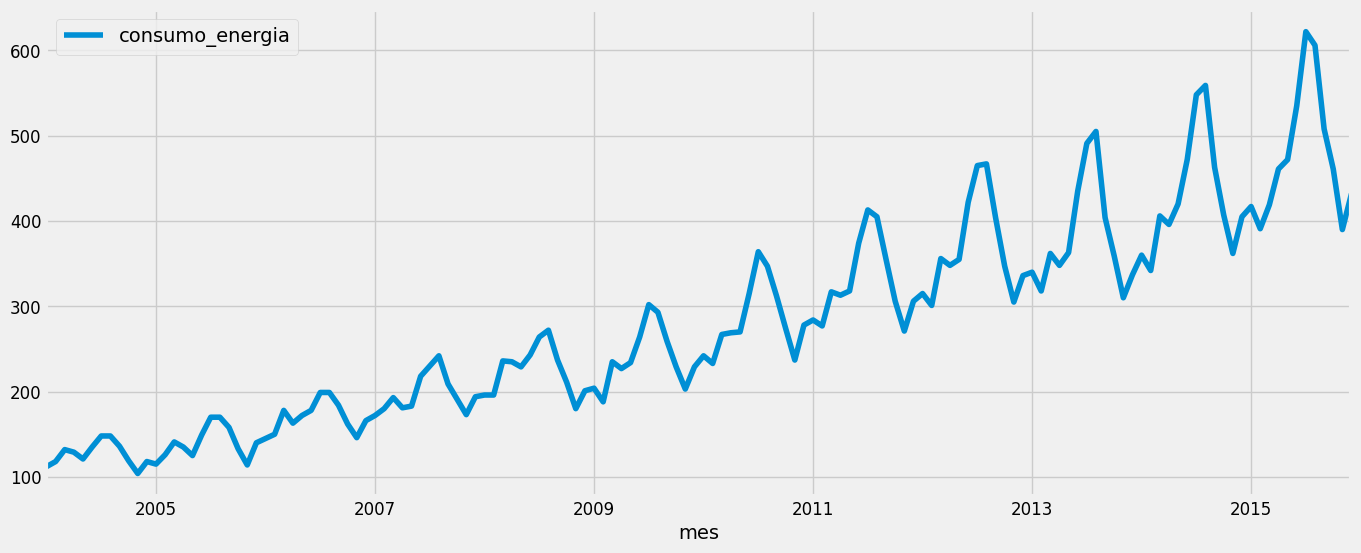

In [ ]:
#plot da série temporal - existe uma tendencia de crescimento
dados_serie.plot(figsize = (15, 6))

O gráfico acima mostra 2 componentes da serie: sazonalidade e tendencia.

* sazonalisdade - o fenomeno se repete em periodos fixos.

* tendencia - ao longo do tempo, a serie segue uma tendência de crescimento.



Outro aspecto a considerar é o comportamento cíclico. Isso acontece quando o padrão de subida e descida da serie não ocorre em intervalos fixos baseados em calendários. deve-se tomar cuidado para não confundir efeito "cíclico" com efeito "sazonal".

Então, como diferenciar um padrão ciclico x sazonal?

Se os padrões não tiverem frequencias fixas baseadas em calendário, será ciclico. Porque, diferentemente da sazonalidade, os efeitos cíclicos são tipicamente influenciados pelos negocios e outros fatores socioeconomicos.

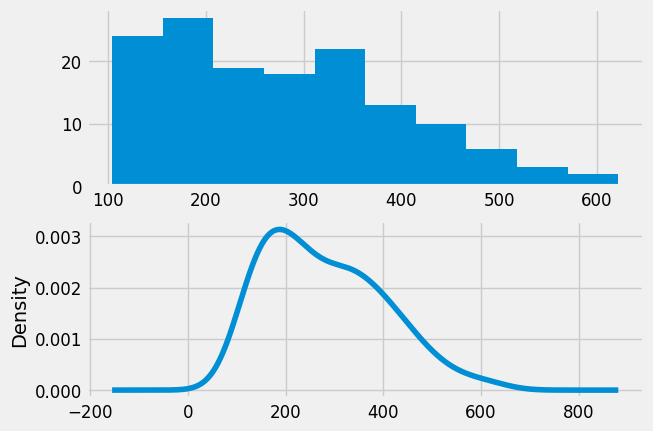

In [ ]:
plt.figure(1) #criar a figura
plt.subplot(211)
dados_serie.consumo_energia.hist()

plt.subplot(212)
dados_serie.consumo_energia.plot(kind= 'kde')
plt.show()

Análise:

* A distribuição não é perfeitamente gaussiana(distribuição normal)
* A distribuição esta inclinada à esquerda
* as transformações podem ser uteis na modelagem.


#BOX PLOTS

Text(0, 0.5, '\nConsumo de energia')

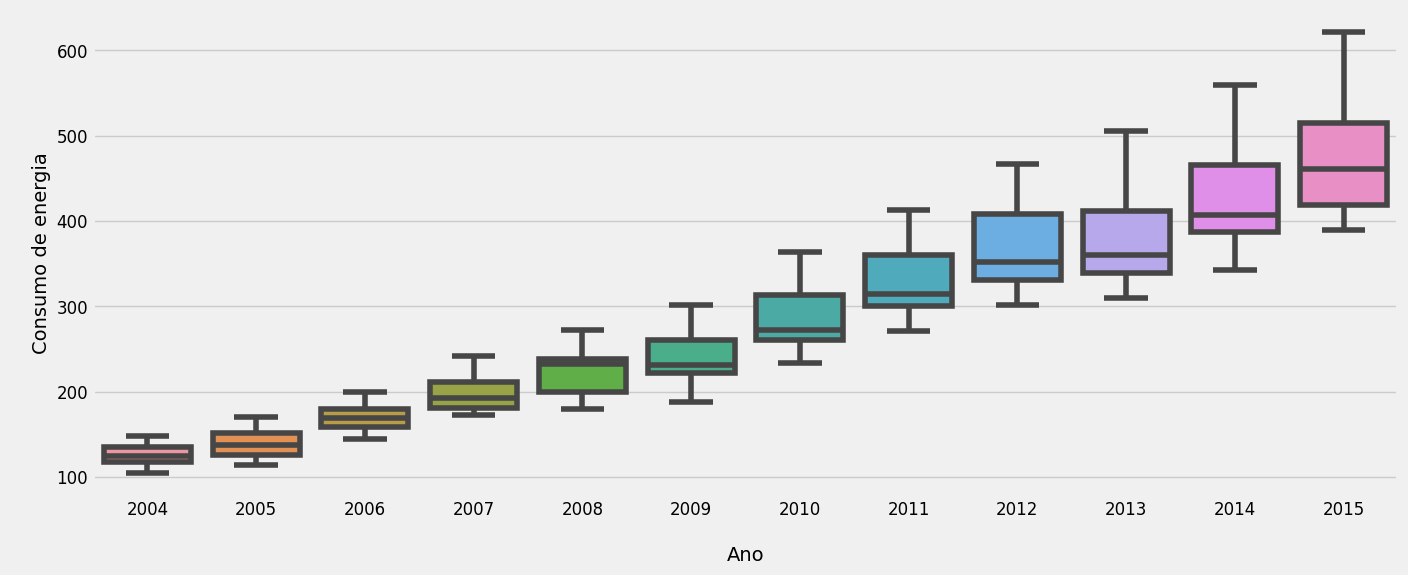

In [ ]:
#Vamos testar:
fig, ax = plt.subplots(figsize = (15,6))

#define as variáveis
indice_ano = dados_serie.consumo_energia.index.year
valor = dados_serie.consumo_energia

#cria um box plot para cada ano usando o seaborn
#dsobserve que estamos extraindo o ano (year) do indice da serie

sns.boxplot(x = indice_ano, y = valor, ax = ax, data = dados_serie)

plt.xlabel('\nAno')
plt.ylabel('\nConsumo de energia')

análise:

* linha(braço) do box plot da parte superior é o valor maximo  e a linha(braço) da parte inferior é o valor minimo. Na caixa, a linha da base é o primeiro quartil. A linha que fica dentro da caixa é a mediana ou segundo quartil. A aresta do topo da caixa é o terceiro quartil. Entao , dentro da caixa ficam os valores entre o 1 º e 3º quartil.

* valores medianos ao longo dos anos confirmam uma tendência ascendente.

* aumento constante da dispersão do meio (mediana) dos dados

* se as caixas estiverem muito achatadas ou muito alargadas, podem significar problemas.

#VISUALIZAÇÃO DA DECOMPOSIÇÃO

DECOMPOSIÇÃO ADITIVA X DECOMPOSIÇÃO MULTIPLICATIVA


A decomposiçaõ aditiva em series temporais é um metodo para desagregar uma serie temporal em componentes diferentes, geralmente tendencia, sazonalidade e ruido. A tendencia representa a variação geral ao longo do tempo, a sazonalidade representa variações regulares ao longo do tempo (como variações mensais ou anuais) e o ruído representa variações aleatórias. A decomposição é chamada "aditiva" porque as componentes são adicionadas juntas para formar a serie temporal original.

A decomposição multiplicativa em series temporais também é um metodo para desagregar uma serie temporal em componentes diferentes, geralmente tendencia, sazonalidade e ruido. a decomposição é chamada 'multiplicativa' porque as componentes são multiplicadas juntas para formar a serie temporal original.

O metodo ideal de decomposição depende do tipo da série.

In [ ]:
#decomposiçao multiplicativa
decomposicao_multiplicativa = sm.tsa.seasonal_decompose(dados_serie,
                                                        model = 'multiplicative',
                                                        extrapolate_trend = 'freq')

In [ ]:
type(decomposicao_multiplicativa)

statsmodels.tsa.seasonal.DecomposeResult

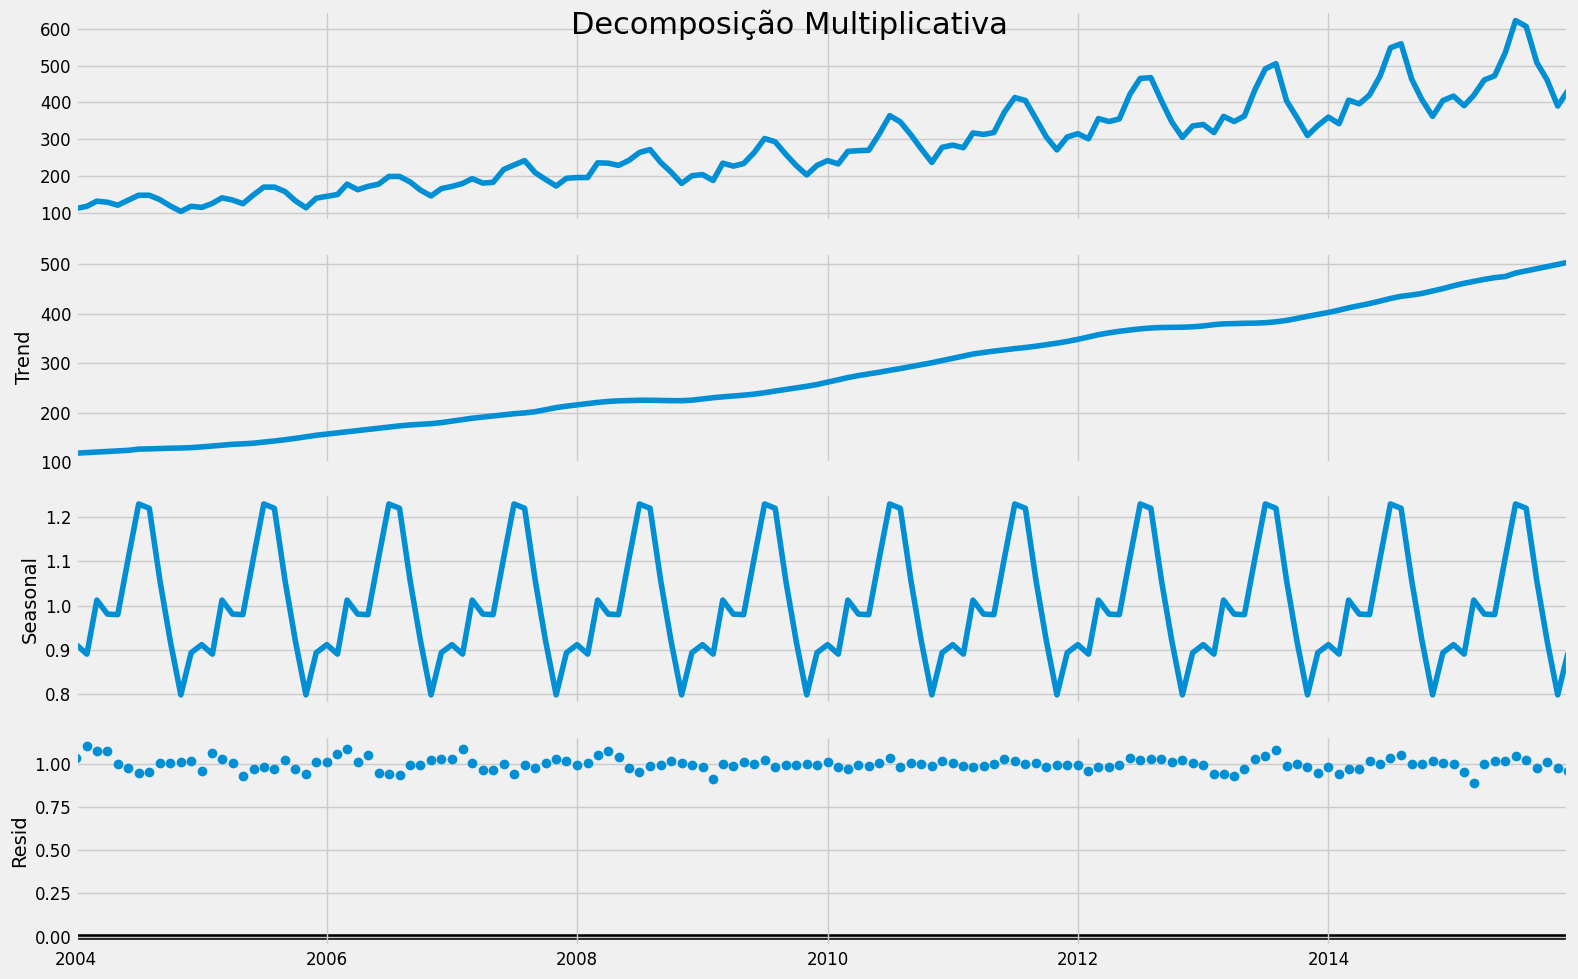

In [ ]:
plt.rcParams.update({'figure.figsize': (16,10)})
decomposicao_multiplicativa.plot().suptitle('Decomposição Multiplicativa', fontsize = 22)
plt.show()

In [ ]:
# Decomposição Aditiva
decomposicao_aditiva = sm.tsa.seasonal_decompose(dados_serie,
                                                 model = 'aditive',
                                                 extrapolate_trend = 'freq')

In [ ]:
type(decomposicao_aditiva)# Decomposição Aditiva
#tipo de objeto

statsmodels.tsa.seasonal.DecomposeResult

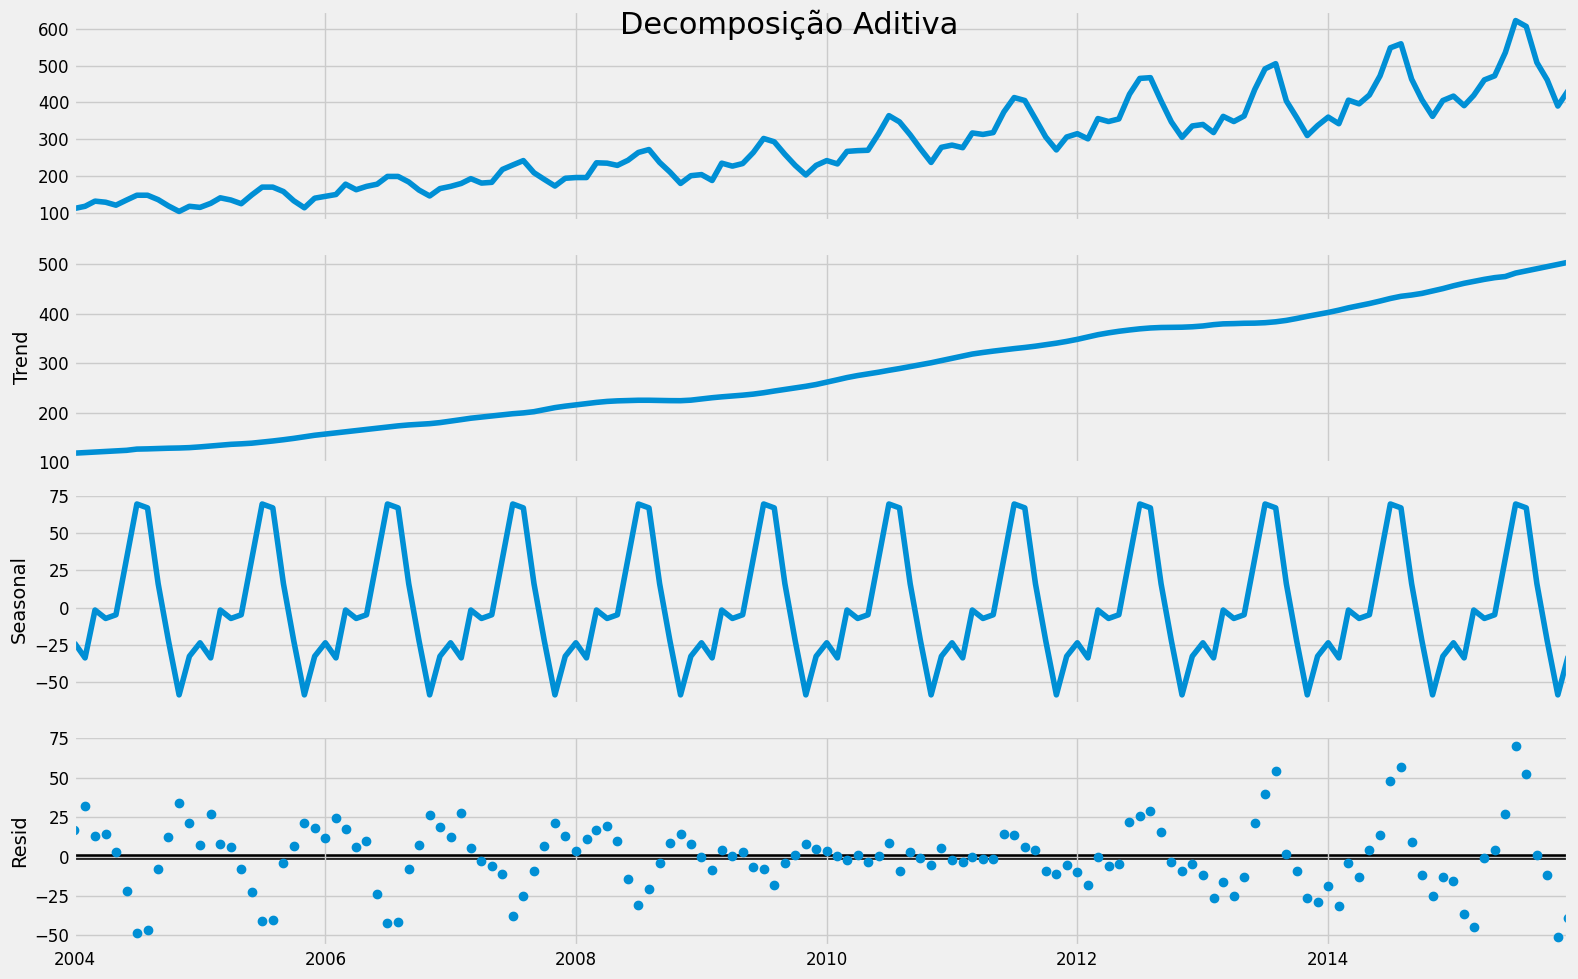

In [ ]:
# Plot
plt.rcParams.update({'figure.figsize': (16,10)})
decomposicao_aditiva.plot().suptitle('Decomposição Aditiva', fontsize = 22)
plt.show()

#Analise da Decomposição da serie

No gráfico acima podemos ver os componentes da serie temporal:

* A primeira linha do gráfico mostra os dados observados, em nosso exemplo o valor do consumo de energia.

* A segunda linha mostra a tendência da série, que claramente é uma tendencia de crescimento, ou seja, o consumo de energia tende a crescer ao longo do tempo.

* A terceira linha mostra a sazonalidade. Claramente temos periodos regulares de aumento e queda, momentos em que temos valores maiores ou menores do consumo de energia. Isso talvez possa ser explicado por eventos baseados em calendário(verão, inverno, férias escolares, etc...)

* A quarta linha é o componente irregular ou resíduo.

Definir **extrapolate_trend = 'freq'** remove valores NaN na tendência e nos residuos(se existirem, é claro).

Se voce observar atentamente os resíduos da decomposição aditiva, ela permanece com algum padrão. A decomposição multiplicativa, no entanto, parece bastante aleatória, o que é bom.

Então, idealmente, a decomposição multiplicativa deve ser preferida para essa série específica.

A saida numérica da tendencia, os componentes sazonais e residuais são armazenados na própria saída decomposicao_multiplicativa. vamos extrai-los e coloca-los em uma tabela de dados.

##EXTRAÇÃO DOS COMPONENTES DA SERIE TEMPORAL

Regra de extração:

Valores reais = Produto da (sazonal*tendencia*residuo)



In [ ]:
# Concatena o resultado da decomposição da série

dados_serie_reconstruida = pd.concat([decomposicao_multiplicativa.seasonal,
                                      decomposicao_multiplicativa.trend,
                                      decomposicao_multiplicativa.resid,
                                      decomposicao_multiplicativa.observed], axis = 1)

In [ ]:
# Define o nome das colunas
dados_serie_reconstruida.columns = ['Sazonalidade', 'Tendência', 'Resíduos', 'Valores_Observados']

In [ ]:
# Mostra o resultado
dados_serie_reconstruida.head()

,Sazonalidade,Tendência,Resíduos,Valores_Observados
mes,,,,
2004-01-01,0.911647,118.588481,1.035974,112.0
2004-02-01,0.890278,119.734169,1.106976,118.0
2004-03-01,1.012327,120.879856,1.078697,132.0
2004-04-01,0.980652,122.025544,1.078013,129.0
2004-05-01,0.979428,123.171232,1.003006,121.0


Se você checar, o produto das colunas Sazonalidade, Tendência e resíduos deve ser exatamente igual a Valores_observados.

Por exemplo:

* serie na data 2001-01-01 = 112.0
* serie na data 2001-01-01 = sazonalidade*tendencia*residuos = 0.911647 * 118.588481 * 1.035974 = 112.0



In [ ]:
# Cálculo em Python
valor_observado = 0.911647 * 118.588481 * 1.035974
print(valor_observado)

112.00001204232605


Ou seja, isso comprova como uma série temporal é na verdade o conjunto de componentes que podem ser extraidos, transformados, analisados e usados para fazer previsoes.



#FIM DA PARTE 1